# Read data from numerical Simulation

The raw data are from the numerical Simulation by Saury et al 2014 (https://ui.adsabs.harvard.edu/abs/2014A&A...567A..16S/abstract)

# Install packages

In [1]:
# ! pip install astroML

In [2]:
# !pip install torch-lr-finder

In [3]:
# ! pip install spectral-cube

# Connect and authorize google drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [5]:
%cd /content/gdrive/My Drive/Colab Notebooks/ML_HI/
!ls

/content/gdrive/My Drive/Colab Notebooks/ML_HI
autoencoder_compress.png       lightning_logs
autoencoder.h5		       MCMC
autoencoder_no_compress.png    MCMC_
best_rs_1.pickle	       MLPClassifier_MLPRegressor.ipynb
best_rs_2.pickle	       MLPRegressor.ipynb
best_rs_3.pickle	       model.png
best_rs_chan400_1.pickle       MRF
catalogged_verification.fits   random_weights.h5
CNN			       rhi_zea.fits
conv_autoencoder.h5	       spec64k.npz
conv_encoder.h5		       tigress
data			       training_data_kok14_galfa.pickle
encoder_compress.png	       transforms
encoder.h5		       Untitled.ipynb
fcnm_zea.fits		       vae
figures			       VAE_decoder.h5
Find_GNOMES_sightlines.ipynb   VAE_encoder.h5
GNOMES_vs_GALFA_spectra.ipynb  VAE.h5
libs			       vae_mlp_decoder.png


In [6]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/ML_HI


# Paths

In [7]:
import sys, os
base_path = os.getcwd()

data_path  = os.path.join(base_path, 'data')
vae_path = os.path.join(base_path, 'vae')
saury_data_path = os.path.join(data_path, 'saury', '')

print(base_path)
print(data_path)

/content/gdrive/My Drive/Colab Notebooks/ML_HI
/content/gdrive/My Drive/Colab Notebooks/ML_HI/data


In [8]:
# 3a. FCNM maps without noise
fcnm_file_q0 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_0.fits'
fcnm_file_q1 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_1.fits'
fcnm_file_q2 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_2.fits'
fcnm_file_q3 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_3.fits'

fcnm_file_q0 = os.path.join(saury_data_path, fcnm_file_q0)
fcnm_file_q1 = os.path.join(saury_data_path, fcnm_file_q1)
fcnm_file_q2 = os.path.join(saury_data_path, fcnm_file_q2)
fcnm_file_q3 = os.path.join(saury_data_path, fcnm_file_q3)

print(fcnm_file_q0)

/content/gdrive/My Drive/Colab Notebooks/ML_HI/data/saury/fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_0.fits


# Libraries

In [9]:
sys.path.insert(1, data_path)

from __future__ import print_function, division
from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage

import glob
import pickle

import torch
from PIL import Image
from torchvision.transforms import ToTensor
from torch.optim import RMSprop

In [10]:
from astropy.wcs import WCS
# from spectral_cube import SpectralCube

# Read training dataset

# Ground-truth cold HI gas fraction

Each spectrum at (Xi, Yi) has a corresponding ground-truth $F_{CNM}$ at the same sky pixel (Xi, Yi).

## $F_{CNM}$ map 1

In [11]:
print('File:', fcnm_file_q0)
fcnm_data_gt1, header = fits.getdata(fcnm_file_q0, header=True)
print(fcnm_data_gt1.shape)

File: /content/gdrive/My Drive/Colab Notebooks/ML_HI/data/saury/fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_0.fits
(512, 512)


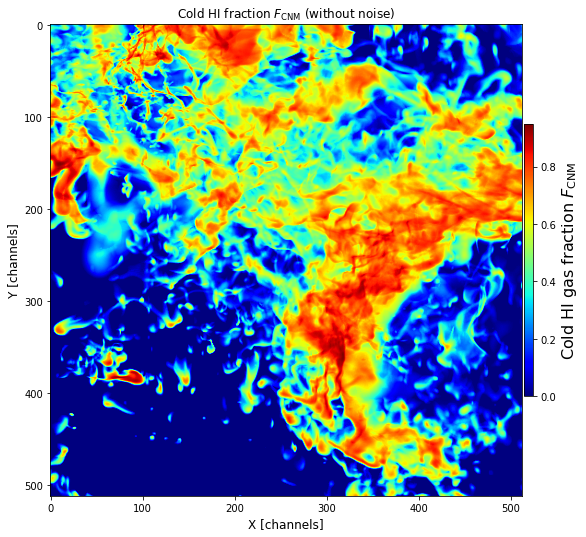

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(fcnm_data_gt1, cmap='jet')

cbar = plt.colorbar(shrink=0.5, pad=0.005, aspect=30)
cbar.set_label('Cold HI gas fraction $F_\mathrm{CNM}$', size=16)

plt.title('Cold HI fraction $F_\mathrm{CNM}$ (without noise)')
plt.ylabel('Y [channels]', fontsize=12)
plt.xlabel('X [channels]', fontsize=12)
plt.show()

## $F_{CNM}$ map 2

In [13]:
print('File:', fcnm_file_q1)
fcnm_data_gt2, header = fits.getdata(fcnm_file_q1, header=True)
print(fcnm_data_gt2.shape)

File: /content/gdrive/My Drive/Colab Notebooks/ML_HI/data/saury/fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_1.fits
(512, 512)


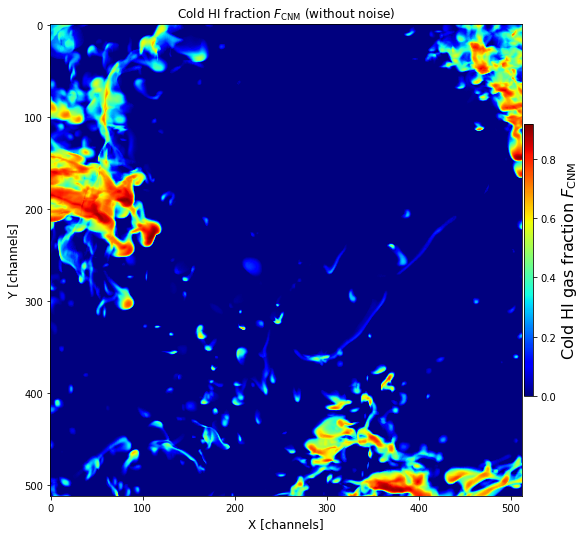

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(fcnm_data_gt2, cmap='jet')

cbar = plt.colorbar(shrink=0.5, pad=0.005, aspect=30)
cbar.set_label('Cold HI gas fraction $F_\mathrm{CNM}$', size=16)

plt.title('Cold HI fraction $F_\mathrm{CNM}$ (without noise)')
plt.ylabel('Y [channels]', fontsize=12)
plt.xlabel('X [channels]', fontsize=12)
plt.show()

## $F_{CNM}$ map 3

In [15]:
print('File:', fcnm_file_q2)
fcnm_data_gt3, header = fits.getdata(fcnm_file_q2, header=True)
print(fcnm_data_gt3.shape)

File: /content/gdrive/My Drive/Colab Notebooks/ML_HI/data/saury/fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_2.fits
(512, 512)


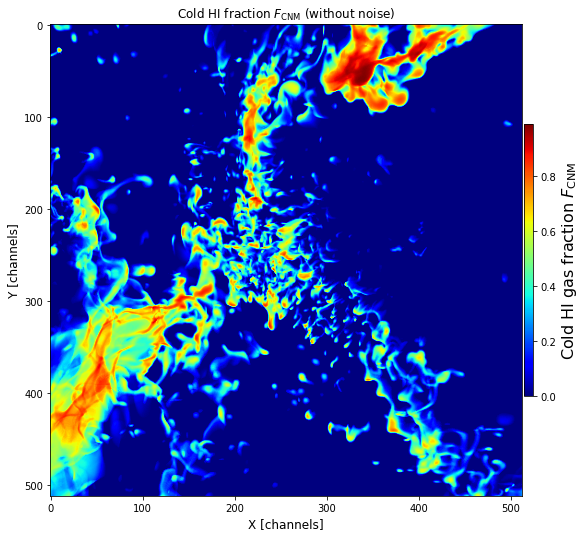

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(fcnm_data_gt3, cmap='jet')

cbar = plt.colorbar(shrink=0.5, pad=0.005, aspect=30)
cbar.set_label('Cold HI gas fraction $F_\mathrm{CNM}$', size=16)

plt.title('Cold HI fraction $F_\mathrm{CNM}$ (without noise)')
plt.ylabel('Y [channels]', fontsize=12)
plt.xlabel('X [channels]', fontsize=12)
plt.show()

## $F_{CNM}$ map 4

In [17]:
print('File:', fcnm_file_q3)
fcnm_data_gt4, header = fits.getdata(fcnm_file_q3, header=True)
print(fcnm_data_gt4.shape)

File: /content/gdrive/My Drive/Colab Notebooks/ML_HI/data/saury/fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_3.fits
(512, 512)


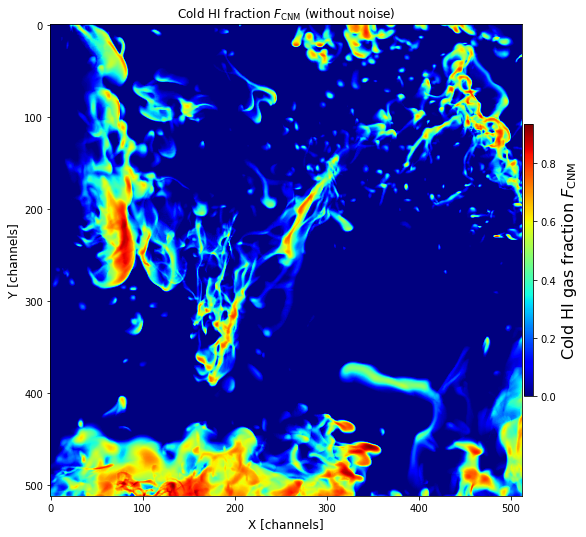

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(fcnm_data_gt4, cmap='jet')

cbar = plt.colorbar(shrink=0.5, pad=0.005, aspect=30)
cbar.set_label('Cold HI gas fraction $F_\mathrm{CNM}$', size=16)

plt.title('Cold HI fraction $F_\mathrm{CNM}$ (without noise)')
plt.ylabel('Y [channels]', fontsize=12)
plt.xlabel('X [channels]', fontsize=12)
plt.show()

# Markov Random Field denoising

Algorithm

Use a quadratic MRF prior $g$ to penalize the difference between neighbouring pixel intensities:

$g(u) = |u|^2$

Start from an image, and update its values using Gradient Descent to minimize the objecttive function:

$f(x,y) = \sum[a(x_i-y_i)^2 + \sum_{n=1}^4g(x_i - x_{i_{n}})]$

where $x_{i_n}$ are 04 surrounding pixels of $x_i$.

Here, instead of calculating gradients manually, we'll take adavantage of Pytorch's autograd.

## $F_{CNM}$ map 1

In [19]:
def get_mismatched_percentage(y, ypred):
    diff = abs(y - ypred) / 2.
    return (100. * np.sum(diff)) / np.size(y)

def mrf_prior(x):
    return x**2

def mrf_loss(x, x_noisy, alpha=1., beta=2.):
    loss1 = ((x_noisy - x)**2).sum()
    loss2 = 0.
    loss2 += mrf_prior(x[:, 1: ] - x[:, :-1]).sum()
    loss2 += mrf_prior(x[:-1, :] - x[1:, :]).sum()
    return alpha*loss1 + beta*loss2

to_tensor = ToTensor()

RRMSE: Relative Root Mean Square Error: calculated by dividing the RMSE with average value of measured data.

RRMSe < 10%: model accuracy is excellent.

10% < RRMSe < 20%: good

20% < RRMSe < 30%: fair

RRMSE > 30%: poor

RRMSE = $100\times\frac{\sqrt{{\frac{1}{n}}\sum_{i=1}^{n}(y-y_{pred})^2}}{∑_{i=1}^{n}y}$

In [20]:
def RRMSE(y, ypred):
  return (((y - ypred)**2).sum() / (y**2).sum())**0.5

#### Add Gaussian noise

In [21]:
# Add noise to image
noise_mean = 0.
noise_sigma = 0.3
img_size = (512, 512)
gaussian_noise = np.random.normal(noise_mean, noise_sigma, img_size)
gnoise_fcnm_data1 = fcnm_data_gt1 + gaussian_noise

# Clip the image values between 0 and 1
gnoise_fcnm_data1 = np.clip(gnoise_fcnm_data1, 0, 0.9)

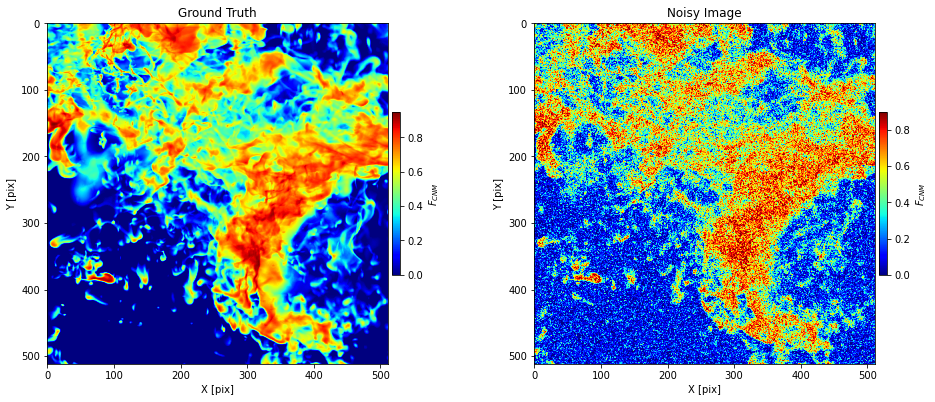

In [22]:
plt.figure(figsize=(16,12))

plt.subplot(121)
plt.title('Ground Truth')
plt.imshow(fcnm_data_gt1, cmap='jet')
plt.colorbar(shrink=0.25, pad=0.01, aspect=20, label='$F_{CNM}$')
plt.xlabel('X [pix]')
plt.ylabel('Y [pix]')

plt.subplot(122)
plt.title('Noisy Image')
plt.imshow(gnoise_fcnm_data1, cmap='jet')
plt.colorbar(shrink=0.25, pad=0.01, aspect=20, label='$F_{CNM}$')
plt.xlabel('X [pix]')
plt.ylabel('Y [pix]')

plt.show()

In [23]:
# Noisy image
gnoise_fcnm_data1 = gnoise_fcnm_data1.astype(np.float32)

# ground-truth
fcnm_data_gt1 = fcnm_data_gt1.astype(np.float32)

In [24]:
y_noisy = to_tensor(gnoise_fcnm_data1)[0].cuda()
y       = to_tensor(fcnm_data_gt1)[0].cuda()

#### Denoise

In [25]:
# Initiate an image
Y = (torch.zeros_like(y_noisy) + torch.mean(y_noisy)).cuda()
Y.requires_grad = True

errors = []
losses = []
images = []
alpha  = 1.
beta = 2.

# Gradient Descent
optimizer = RMSprop([Y])

# Number of iterations
n_it = 1000

In [26]:
for it in range(n_it):
    # explicitly set the gradients to zero before starting doing backpropragation
    # (i.e., updating the Weights and biases)
    # because PyTorch accumulates the gradients on subsequent backward passes. 
    optimizer.zero_grad()

    # Loss function
    loss = mrf_loss(Y, y_noisy, alpha, beta)

    # computes dloss/dx for every parameter x which has requires_grad=True.
    loss.backward()

    # update parameters
    optimizer.step()

    errors.append(RRMSE(y, Y).item())
    losses.append(loss.item())
    images.append(np.array(255*Y.cpu().detach()).astype(np.uint8))
# Endfor
print("RRMSE Initial: {}".format(RRMSE(y, y_noisy)))
print("RRMSE Final  : {}".format(errors[-1]))

RRMSE Initial: 0.5423951148986816
RRMSE Final  : 0.22323065996170044


#### Results

In [27]:
# Denoise image
denoised_image = np.absolute(Y.detach().cpu().numpy())

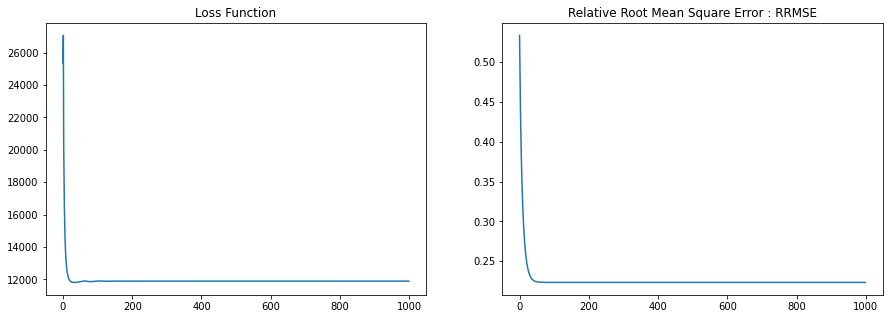

In [28]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('Loss Function')
plt.plot(losses)

plt.subplot(122)
plt.title('Relative Root Mean Square Error : RRMSE')
plt.plot(errors)

plt.show()

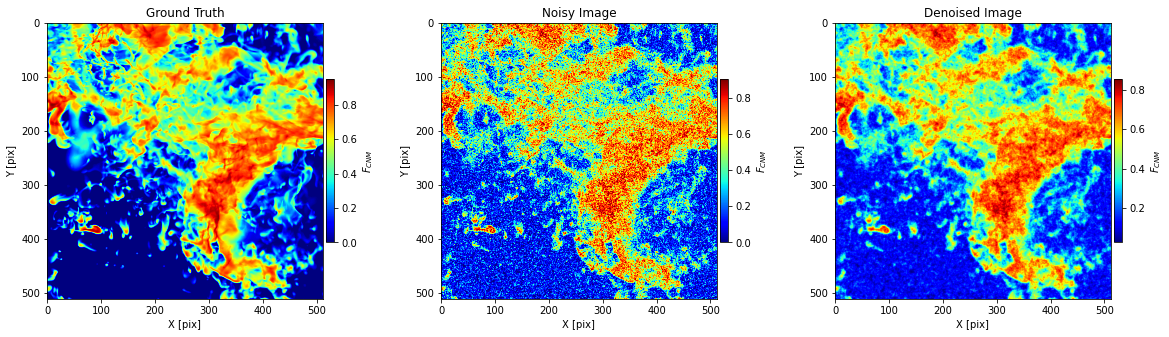

In [29]:
plt.figure(figsize=(20,12))

plt.subplot(131)
plt.title('Ground Truth')
plt.imshow(fcnm_data_gt1, cmap='jet')
plt.colorbar(shrink=0.25, pad=0.01, aspect=20, label='$F_{CNM}$')
plt.xlabel('X [pix]')
plt.ylabel('Y [pix]')

plt.subplot(132)
plt.title('Noisy Image')
plt.imshow(gnoise_fcnm_data1, cmap='jet')
plt.colorbar(shrink=0.25, pad=0.01, aspect=20, label='$F_{CNM}$')
plt.xlabel('X [pix]')
plt.ylabel('Y [pix]')

plt.subplot(133)
plt.title('Denoised Image')
plt.imshow(denoised_image, cmap='jet')
plt.colorbar(shrink=0.25, pad=0.01, aspect=20, label='$F_{CNM}$')
plt.xlabel('X [pix]')
plt.ylabel('Y [pix]')

plt.show()

The difference between ground-truth and denoised images

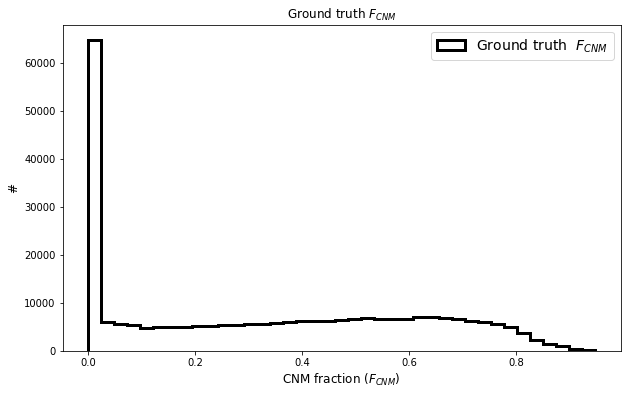

In [30]:
# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(fcnm_data_gt1.flatten(), bins=np.linspace(0., fcnm_data_gt1.flatten().max(), 40),
         density=False, color='k', histtype='step',
         alpha=1., ls='-', lw=3,
         label='Ground truth  $F_{CNM}$')

plt.title('Ground truth $F_{CNM}$')
plt.xlabel(r'CNM fraction ($F_{CNM}$)', fontsize=12)
plt.ylabel(r'#', fontsize=12)

plt.legend(loc='upper right', fontsize=14)
plt.show()

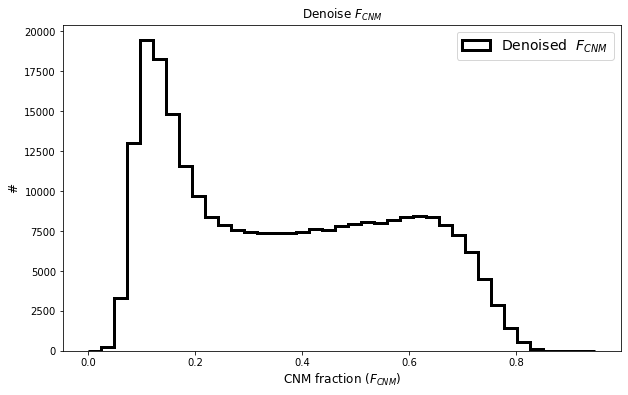

In [31]:
# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(denoised_image.flatten(), bins=np.linspace(0., fcnm_data_gt1.flatten().max(), 40),
         density=False, color='k', histtype='step',
         alpha=1., ls='-', lw=3,
         label='Denoised  $F_{CNM}$')

plt.title('Denoise $F_{CNM}$')
plt.xlabel(r'CNM fraction ($F_{CNM}$)', fontsize=12)
plt.ylabel(r'#', fontsize=12)

plt.legend(loc='upper right', fontsize=14)
plt.show()

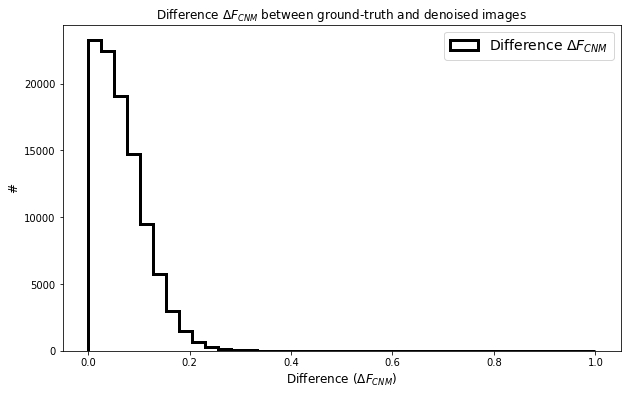

In [32]:
# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist((fcnm_data_gt1-denoised_image).flatten(), bins=np.linspace(0., 1., 40),
         density=False, color='k', histtype='step',
         alpha=1., ls='-', lw=3,
         label='Difference $\Delta F_{CNM}$')

plt.title('Difference $\Delta F_{CNM}$ between ground-truth and denoised images')
plt.xlabel(r'Difference ($\Delta F_{CNM}$)', fontsize=12)
plt.ylabel(r'#', fontsize=12)

plt.legend(loc='upper right', fontsize=14)
plt.show()

In [33]:
# print the percentage of mismatched pixels
print ('Percentage of mismatched pixels (Ground-truth vs Denoised images): %.5f ' %(get_mismatched_percentage(fcnm_data_gt1, denoised_image)))

Percentage of mismatched pixels (Ground-truth vs Denoised images): 4.07507 


In [34]:
# print the percentage of mismatched pixels
print ('Percentage of mismatched pixels (Ground-truth vs noisy images): %.5f ' %(get_mismatched_percentage(fcnm_data_gt1, gnoise_fcnm_data1)))

Percentage of mismatched pixels (Ground-truth vs noisy images): 8.87418 


The difference between ground-truth and noisy images

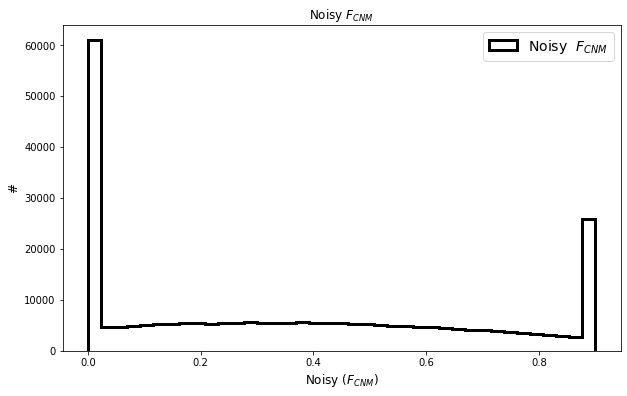

In [35]:
# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist(gnoise_fcnm_data1.flatten(), bins=np.linspace(0., gnoise_fcnm_data1.flatten().max(), 40),
         density=False, color='k', histtype='step',
         alpha=1., ls='-', lw=3,
         label='Noisy  $F_{CNM}$')

plt.title('Noisy $F_{CNM}$')
plt.xlabel(r'Noisy ($F_{CNM}$)', fontsize=12)
plt.ylabel(r'#', fontsize=12)

plt.legend(loc='upper right', fontsize=14)
plt.show()

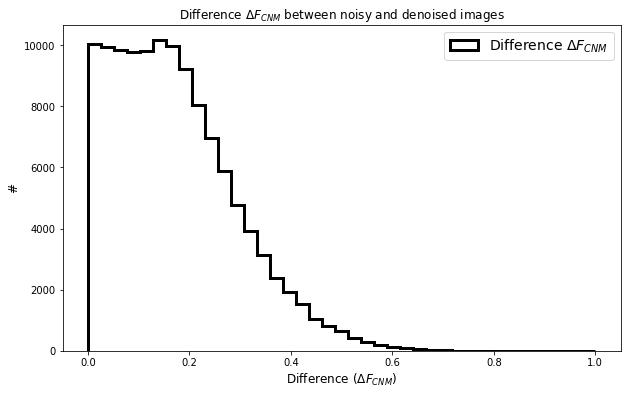

In [36]:
# Plot histograms
plt.figure(figsize=(10, 6))

plt.hist((gnoise_fcnm_data1-denoised_image).flatten(), bins=np.linspace(0., 1., 40),
         density=False, color='k', histtype='step',
         alpha=1., ls='-', lw=3,
         label='Difference $\Delta F_{CNM}$')

plt.title('Difference $\Delta F_{CNM}$ between noisy and denoised images')
plt.xlabel(r'Difference ($\Delta F_{CNM}$)', fontsize=12)
plt.ylabel(r'#', fontsize=12)

plt.legend(loc='upper right', fontsize=14)
plt.show()

In [37]:
# print the percentage of mismatched pixels
print('Percentage of mismatched pixels (Denoised vs Noisy images): %.5f ' %(get_mismatched_percentage(denoised_image, gnoise_fcnm_data1)))

Percentage of mismatched pixels (Denoised vs Noisy images): 7.97051 
